In [10]:
import os

import torch
import torch.nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# OpenCV
import cv2

# plotting
import matplotlib.pyplot as plt
import json

# Let's Visualise random images and mask of that image from the dataset

In [131]:
image_path = "/Users/akhil/Documents/Machine learning/Mas-Roads-Dataset/tiff/train/"
mask_path = "/Users/akhil/Documents/Machine learning/Mas-Roads-Dataset/tiff/train_labels/"
images = []
masks = []
for idx, file in enumerate(os.listdir(image_path)):
    images.append(file)
    
for idx, file in enumerate(os.listdir(mask_path)):
    masks.append(file)

images.sort()
masks.sort()

random_samples = random.sample(range(len(images)), k = 4)
random_samples

[164, 73, 975, 88]

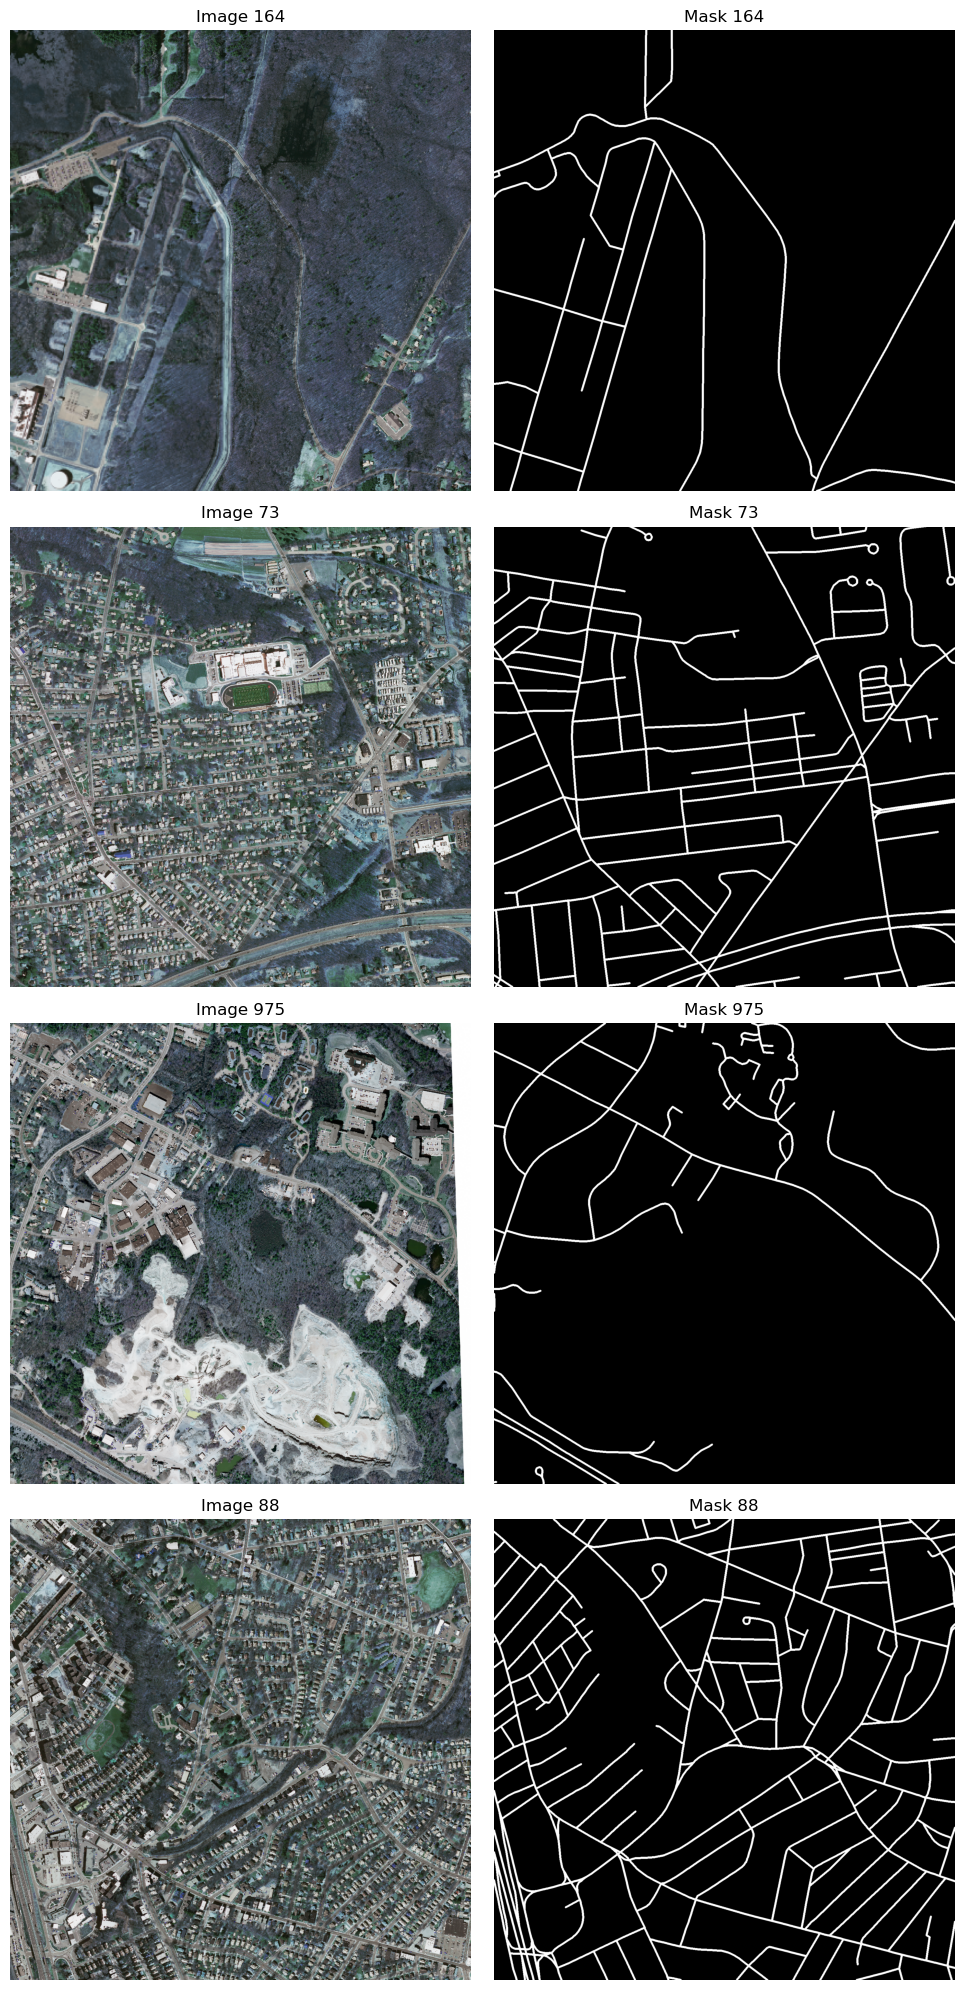

In [134]:

fig, axs = plt.subplots(4,2, figsize=(10, 20))
for ind, index in enumerate(random_samples):
    if ind > 3:
        break;
    image = cv2.imread(os.path.join(image_path,images[random_samples[ind]]))
    mask = cv2.imread(os.path.join(mask_path,masks[random_samples[ind]]))

    axs[ind, 0].imshow(image)
    axs[ind, 0].set_title(f'Image {index}')
    axs[ind, 0].axis('off')

    # Show mask in the right column
    axs[ind, 1].imshow(mask)
    axs[ind, 1].set_title(f'Mask {index}')
    axs[ind, 1].axis('off')

plt.tight_layout()

# Show the plot
plt.show()